In [15]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
import xml.etree.ElementTree as et
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import gdown

In [23]:
# cur_dir = os.getcwd()
cur_dir = './'
data_dir = os.path.join(cur_dir, 'oxford_pet')
image_dir = os.path.join(data_dir, 'images')
bbox_dir = os.path.join(data_dir, 'annotations', 'xmls')

In [24]:
# 이미지 갯수
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
n_images = len(image_files)
print(n_images)

7390


In [25]:
# xml 파일
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']
n_bboxes = len(bbox_files)
print(n_bboxes)

3686


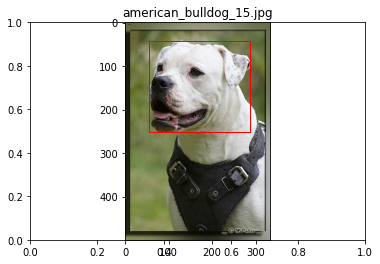

In [27]:
# 구조
rnd_idx = random.randint(0, n_bboxes-1)

bbox_name = bbox_files[rnd_idx]
bbox_path = os.path.join(bbox_dir, bbox_name)
tree = et.parse(bbox_path)

xmin = float(tree.find('./object/bndbox/xmin').text)
ymin = float(tree.find('./object/bndbox/ymin').text)
xmax = float(tree.find('./object/bndbox/xmax').text)
ymax = float(tree.find('./object/bndbox/ymax').text)

rect_x = xmin
rect_y = ymin
rect_w = xmax - xmin
rect_h = ymax - ymin

# Abyssinian_1.xml --> Abyssinian.jpg
fname = os.path.splitext(bbox_name)[0]+'.jpg'
fpath = os.path.join(image_dir, fname)
image = Image.open(fpath)
image = np.array(image)

rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
plt.title(fname)
plt.axes().add_patch(rect)
plt.imshow(image)
plt.show()

In [28]:
## image file들을 읽어서 channel이 3이 아닌 image는 삭제
for image_file in image_files:
  image_path = os.path.join(image_dir, image_file)
  bbox_file = os.path.splitext(image_file)[0]+'.xml'
  bbox_path = os.path.join(bbox_dir, bbox_file)
  image = Image.open(image_path)
  image_mode = image.mode
  if image_mode != 'RGB':
    print(image_file, image_mode)
    image = np.asarray(image)
    print(image.shape)
    os.remove(image_path)
    try:
      os.remove(bbox_path)
    except FileNotFoundError:
      pass

Abyssinian_34.jpg P
(202, 250)
Abyssinian_5.jpg RGBA
(150, 200, 4)
Egyptian_Mau_129.jpg L
(325, 299)
Egyptian_Mau_139.jpg P
(250, 350)
Egyptian_Mau_14.jpg RGBA
(800, 582, 4)
Egyptian_Mau_145.jpg P
(188, 216)
Egyptian_Mau_167.jpg P
(275, 183)
Egyptian_Mau_177.jpg P
(175, 246)
Egyptian_Mau_186.jpg RGBA
(275, 183, 4)
Egyptian_Mau_191.jpg P
(214, 300)
staffordshire_bull_terrier_2.jpg L
(282, 500)
staffordshire_bull_terrier_22.jpg L
(500, 364)


In [29]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
n_images = len(image_files)
print(n_images)

7378


In [30]:
## localization을 위한 bounding box 정보가 있는 xml file의 수 확인
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']
n_bboxes = len(bbox_files)
print(n_bboxes)

3685


In [40]:
## hyperparameters
IMG_SIZE = 224
N_DATA = 3685
N_TRAIN = 3000
N_VAL = 685


N_EPOCHS = 40
N_BATCH = 40
N_VAL_BATCH = 137
learning_rate = 0.0001

In [32]:
## train/validation data 나누기
shuffle_list = list(range(N_DATA))
random.shuffle(shuffle_list)

train_idx_list = shuffle_list[:N_TRAIN]
val_idx_list = shuffle_list[N_TRAIN:]

In [33]:
## TFRecord 저장할 directory와 file 경로 설정
tfr_dir = os.path.join(data_dir, 'tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'loc_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'loc_val.tfr')

In [34]:
## TFRecord writer 생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [37]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [38]:
for idx in train_idx_list:
  bbox_file = bbox_files[idx]
  bbox_path = os.path.join(bbox_dir, bbox_file)

  tree = et.parse(bbox_path)
  width = float(tree.find('./size/width').text)
  height = float(tree.find('./size/height').text)
  xmin = float(tree.find('./object/bndbox/xmin').text)
  ymin = float(tree.find('./object/bndbox/ymin').text)
  xmax = float(tree.find('./object/bndbox/xmax').text)
  ymax = float(tree.find('./object/bndbox/ymax').text)
  xc = (xmin + xmax) / 2.
  yc = (ymin + ymax) / 2.
  x = xc / width
  y = yc / height
  w = (xmax - xmin) / width
  h = (ymax - ymin) / height

  file_name = os.path.splitext(bbox_file)[0]
  image_file = file_name + '.jpg'
  image_path = os.path.join(image_dir, image_file)
  image = Image.open(image_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  if file_name[0].islower():
    cls_num = 0
  else:
    cls_num = 1
  
  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),      
      'cls_num': _int64_feature(cls_num),
      'x': _float_feature(x),
      'y': _float_feature(y),
      'w': _float_feature(w),
      'h': _float_feature(h)
  }))
  writer_train.write(example.SerializeToString())

writer_train.close()

In [39]:
for idx in val_idx_list:
  bbox_file = bbox_files[idx]
  bbox_path = os.path.join(bbox_dir, bbox_file)

  tree = et.parse(bbox_path)
  width = float(tree.find('./size/width').text)
  height = float(tree.find('./size/height').text)
  xmin = float(tree.find('./object/bndbox/xmin').text)
  ymin = float(tree.find('./object/bndbox/ymin').text)
  xmax = float(tree.find('./object/bndbox/xmax').text)
  ymax = float(tree.find('./object/bndbox/ymax').text)
  xc = (xmin + xmax) / 2.
  yc = (ymin + ymax) / 2.
  x = xc / width
  y = yc / height
  w = (xmax - xmin) / width
  h = (ymax - ymin) / height

  file_name = os.path.splitext(bbox_file)[0]
  image_file = file_name + '.jpg'
  image_path = os.path.join(image_dir, image_file)
  image = Image.open(image_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  if file_name[0].islower():
    cls_num = 0
  else:
    cls_num = 1
  
  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(cls_num),
      'x': _float_feature(x),
      'y': _float_feature(y),
      'w': _float_feature(w),
      'h': _float_feature(h)
  }))
  writer_val.write(example.SerializeToString())

writer_val.close()

In [41]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),              
              'x': tf.io.FixedLenFeature([], tf.float32),
              'y': tf.io.FixedLenFeature([], tf.float32),
              'w': tf.io.FixedLenFeature([], tf.float32),
              'h': tf.io.FixedLenFeature([], tf.float32)              
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255.
    
    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    gt = tf.stack([x, y, w, h], -1)
    
    return image, gt

In [42]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH)

In [43]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(N_VAL_BATCH)

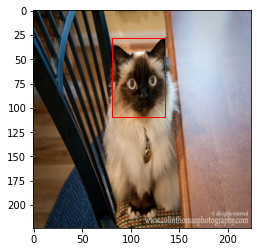

In [44]:
## validation dataset에서 첫번째 image와 bbox를 읽어서 확인
for image, gt in val_dataset.take(1):
      
  '''그림을 그리기 위해서 bbox의 왼쪽 위 꼭지점 좌표를 계산하고, 
  xmin, ymin, w, h 각각을 image size에 맞게 scaling'''
  x = gt[:,0]
  y = gt[:,1]
  w = gt[:,2]
  h = gt[:,3]
  xmin = x[0].numpy() - w[0].numpy()/2.
  ymin = y[0].numpy() - h[0].numpy()/2.
  rect_x = int(xmin * IMG_SIZE)
  rect_y = int(ymin * IMG_SIZE)
  rect_w = int(w[0].numpy() * IMG_SIZE)
  rect_h = int(h[0].numpy() * IMG_SIZE)

  rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
  plt.axes().add_patch(rect)
  plt.imshow(image[0])
  plt.show()

In [45]:
# Sequential API를 사용하여 model 구성
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32, 3, activation='relu', padding='SAME', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))

    model.add(keras.layers.Conv2D(64, 3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(128, 3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))

    model.add(keras.layers.Conv2D(256, 3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(256, 3, activation='relu', padding='SAME'))
    
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(4, activation='sigmoid'))
    return model

## Create model, compile & summary
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       2

In [46]:
def loss_fn(y_true, y_pred):
  return keras.losses.MeanSquaredError()(y_true, y_pred)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=N_TRAIN/N_BATCH*10,
                                                          decay_rate=0.5,
                                                          staircase=True)
model.compile(keras.optimizers.RMSprop(lr_schedule, momentum=0.9), loss=loss_fn)

In [47]:
model.fit(train_dataset, epochs=N_EPOCHS, validation_data=val_dataset)

Epoch 1/40
75/75 [==============================] - 14s 91ms/step - loss: 0.0241 - val_loss: 0.0226
Epoch 2/40
75/75 [==============================] - 6s 66ms/step - loss: 0.0234 - val_loss: 0.0221
Epoch 3/40
75/75 [==============================] - 6s 66ms/step - loss: 0.0224 - val_loss: 0.0236
Epoch 4/40
75/75 [==============================] - 6s 68ms/step - loss: 0.0214 - val_loss: 0.0200
Epoch 5/40
75/75 [==============================] - 6s 65ms/step - loss: 0.0204 - val_loss: 0.0192
Epoch 6/40
75/75 [==============================] - 6s 66ms/step - loss: 0.0193 - val_loss: 0.0190
Epoch 7/40
75/75 [==============================] - 6s 65ms/step - loss: 0.0191 - val_loss: 0.0198
Epoch 8/40
75/75 [==============================] - 6s 65ms/step - loss: 0.0176 - val_loss: 0.0167
Epoch 9/40
75/75 [==============================] - 6s 65ms/step - loss: 0.0166 - val_loss: 0.0182
Epoch 10/40
75/75 [==============================] - 6s 66ms/step - loss: 0.0160 - val_loss: 0.0155
Epoch 11

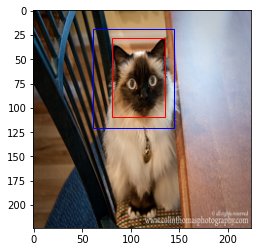

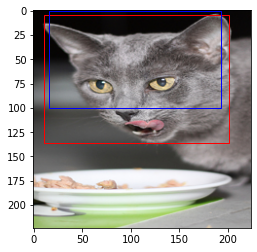

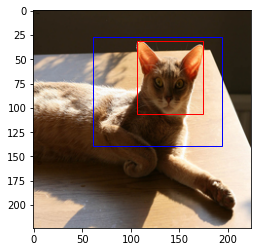

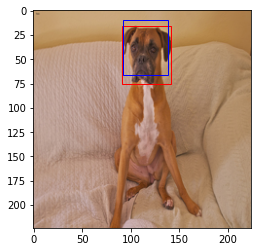

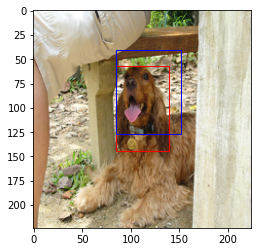

In [66]:
idx = 0
for val_data, val_gt in val_dataset:
  fig, ax = plt.subplots()
      
  plt.imshow(val_data[idx])
      
  x = val_gt[:,0]
  y = val_gt[:,1]
  w = val_gt[:,2]
  h = val_gt[:,3]
  xmin = x[idx].numpy() - w[idx].numpy()/2.
  ymin = y[idx].numpy() - h[idx].numpy()/2.
  rect_x = int(xmin * IMG_SIZE)
  rect_y = int(ymin * IMG_SIZE)
  rect_w = int(w[idx].numpy() * IMG_SIZE)
  rect_h = int(h[idx].numpy() * IMG_SIZE)

  rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
  # plt.axes().add_patch(rect)
  ax.add_patch(rect)

  prediction = model.predict(val_data)
  pred_x = prediction[:,0]
  pred_y = prediction[:,1]
  pred_w = prediction[:,2]
  pred_h = prediction[:,3]
  pred_xmin = pred_x[idx] - pred_w[idx]/2.
  pred_ymin = pred_y[idx] - pred_h[idx]/2.
  pred_rect_x = int(pred_xmin * IMG_SIZE)
  pred_rect_y = int(pred_ymin * IMG_SIZE)
  pred_rect_w = int(pred_w[idx] * IMG_SIZE)
  pred_rect_h = int(pred_h[idx] * IMG_SIZE)

  pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                        fill=False, color='blue')
  # plt.axes().add_patch(pred_rect)
  ax.add_patch(pred_rect)

  
  plt.show()

In [ ]:
plt.axes()

In [56]:
pred_rect_x, pred_rect_y, pred_rect_w, pred_rect_h

(85, 40, 67, 87)

In [52]:
avg_iou = 0
for val_data, val_gt in val_dataset:
  x = val_gt[:,0]
  y = val_gt[:,1]
  w = val_gt[:,2]
  h = val_gt[:,3]
  prediction = model.predict(val_data)
  pred_x = prediction[:,0]
  pred_y = prediction[:,1]
  pred_w = prediction[:,2]
  pred_h = prediction[:,3]
  for idx in range(N_VAL_BATCH):
    xmin = int((x[idx].numpy() - w[idx].numpy()/2.)*IMG_SIZE)
    ymin = int((y[idx].numpy() - h[idx].numpy()/2.)*IMG_SIZE)
    xmax = int((x[idx].numpy() + w[idx].numpy()/2.)*IMG_SIZE)
    ymax = int((y[idx].numpy() + h[idx].numpy()/2.)*IMG_SIZE)

    pred_xmin = int((pred_x[idx] - pred_w[idx]/2.)*IMG_SIZE)
    pred_ymin = int((pred_y[idx] - pred_h[idx]/2.)*IMG_SIZE)
    pred_xmax = int((pred_x[idx] + pred_w[idx]/2.)*IMG_SIZE)
    pred_ymax = int((pred_y[idx] + pred_h[idx]/2.)*IMG_SIZE)

    if xmin > pred_xmax or xmax < pred_xmin:
      continue
    if ymin > pred_ymax or ymax < pred_ymin:
      continue

    w_inter = np.min((xmax, pred_xmax)) - np.max((xmin, pred_xmin))
    h_inter = np.min((ymax, pred_ymax)) - np.max((ymin, pred_ymin))
    inter = w_inter * h_inter
    union = (w[idx].numpy()*h[idx].numpy() + pred_w[idx]*pred_h[idx])*IMG_SIZE*IMG_SIZE - inter

    iou = inter / union
    avg_iou += iou / N_VAL

print(avg_iou)

0.521627041046786


In [67]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate

In [68]:
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [71]:
def mv2_model():
    model = keras.models.Sequential()
    model.add(mobilenetv2)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(4, activation='sigmoid'))
    return model

model = mv2_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               327936    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)               

In [72]:
def loss_fn(y_true, y_pred):
      return keras.losses.MeanSquaredError()(y_true, y_pred)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=N_TRAIN/N_BATCH*10,
                                                          decay_rate=0.5,
                                                          staircase=True)
model.compile(keras.optimizers.RMSprop(lr_schedule, momentum=0.9), loss=loss_fn)

In [73]:
## Train!
model.fit(train_dataset, epochs=N_EPOCHS, validation_data=val_dataset)

Epoch 1/40
75/75 [==============================] - 34s 255ms/step - loss: 0.0192 - val_loss: 0.0413
Epoch 2/40
75/75 [==============================] - 17s 211ms/step - loss: 0.0059 - val_loss: 0.0332
Epoch 3/40
75/75 [==============================] - 17s 211ms/step - loss: 0.0033 - val_loss: 0.0218
Epoch 4/40
75/75 [==============================] - 17s 209ms/step - loss: 0.0027 - val_loss: 0.0177
Epoch 5/40
75/75 [==============================] - 17s 210ms/step - loss: 0.0022 - val_loss: 0.0147
Epoch 6/40
75/75 [==============================] - 17s 211ms/step - loss: 0.0019 - val_loss: 0.0106
Epoch 7/40
75/75 [==============================] - 17s 209ms/step - loss: 0.0018 - val_loss: 0.0089
Epoch 8/40
75/75 [==============================] - 17s 210ms/step - loss: 0.0016 - val_loss: 0.0082
Epoch 9/40
75/75 [==============================] - 17s 209ms/step - loss: 0.0016 - val_loss: 0.0074
Epoch 10/40
75/75 [==============================] - 17s 210ms/step - loss: 0.0016 - val_lo

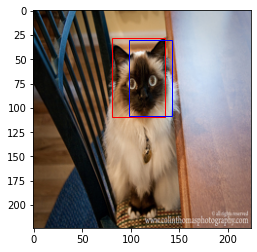

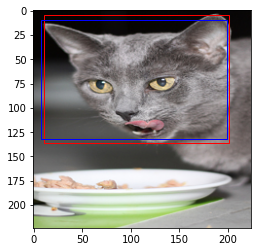

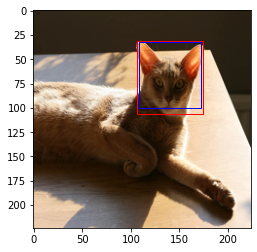

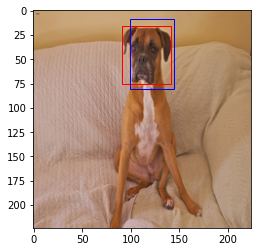

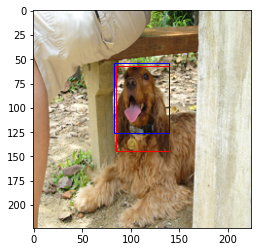

In [74]:
idx = 0
for val_data, val_gt in val_dataset:
  fig, ax = plt.subplots()
      
  plt.imshow(val_data[idx])
      
  x = val_gt[:,0]
  y = val_gt[:,1]
  w = val_gt[:,2]
  h = val_gt[:,3]
  xmin = x[idx].numpy() - w[idx].numpy()/2.
  ymin = y[idx].numpy() - h[idx].numpy()/2.
  rect_x = int(xmin * IMG_SIZE)
  rect_y = int(ymin * IMG_SIZE)
  rect_w = int(w[idx].numpy() * IMG_SIZE)
  rect_h = int(h[idx].numpy() * IMG_SIZE)

  rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
  # plt.axes().add_patch(rect)
  ax.add_patch(rect)

  prediction = model.predict(val_data)
  pred_x = prediction[:,0]
  pred_y = prediction[:,1]
  pred_w = prediction[:,2]
  pred_h = prediction[:,3]
  pred_xmin = pred_x[idx] - pred_w[idx]/2.
  pred_ymin = pred_y[idx] - pred_h[idx]/2.
  pred_rect_x = int(pred_xmin * IMG_SIZE)
  pred_rect_y = int(pred_ymin * IMG_SIZE)
  pred_rect_w = int(pred_w[idx] * IMG_SIZE)
  pred_rect_h = int(pred_h[idx] * IMG_SIZE)

  pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                        fill=False, color='blue')
  # plt.axes().add_patch(pred_rect)
  ax.add_patch(pred_rect)

  
  plt.show()